## Demo Notebook


### Basic usage

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter as draw

ghz_circ = Circuit(3).H(0).CX(0, 1).CX(0, 2)
ghz_circ.add_barrier([0, 1, 2])
ghz_circ.measure_all()

draw(ghz_circ)

In [2]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

result = backend.run_circuit(ghz_circ, n_shots=1000)
print(result.get_counts())

Counter({(0, 0, 0): 520, (1, 1, 1): 480})


## Converting circuits (pytket<->qiskit)

### Basic circuits

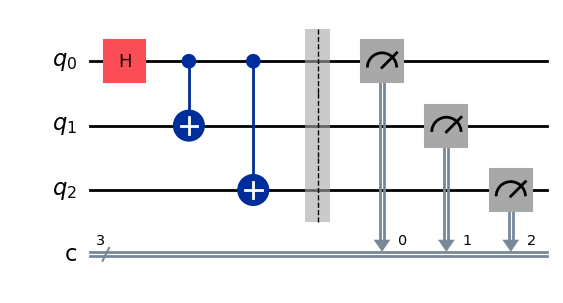

In [3]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_ghz = tk_to_qiskit(ghz_circ)

qiskit_ghz.draw("mpl")

### Converting some higher level circuit operations

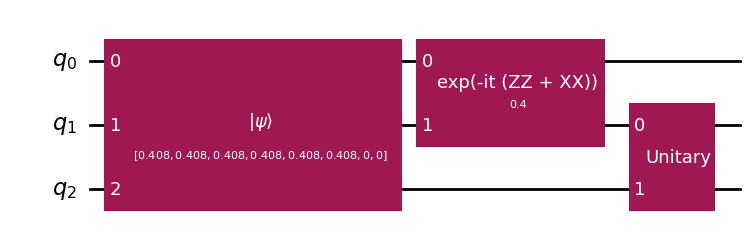

In [4]:
from qiskit import QuantumCircuit
from pytket.extensions.qiskit import qiskit_to_tk
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
import numpy as np

qiskit_qc = QuantumCircuit(3)

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")

zzxx_operator = (Z ^ Z) - 0.1 * (X ^ X)
evo_gate = PauliEvolutionGate(zzxx_operator, time=0.4)

two_qubit_unitary = 0.5 * np.array([
    [1, 1, 1, 1],
    [-1, 1, -1, 1],
    [-1, -1, 1, 1],
    [-1, 1, 1, -1]
])

my_state = 1 / np.sqrt(6) * np.array([1, 1, 1, 1, 1, 1, 0, 0])

qiskit_qc.initialize(my_state)
qiskit_qc.append(evo_gate, [0, 1])
qiskit_qc.unitary(two_qubit_unitary, [1, 2])

qiskit_qc.draw("mpl")

In [5]:
pytket_w_state_circ = qiskit_to_tk(qiskit_qc)
draw(pytket_w_state_circ)

### Controlled gates and `ConjugationBox`

Idea: If we have an operation of the form $U = V \, A \, V^\dagger$ . We can construct a controlled $U$ by only contolling on the central $A$ operation 

Compute ($U$) - Action ($A$) - Uncompute ($U^\dagger$)


$$
C[U] =  (I \otimes V) \, C[A] (I \otimes V^\dagger) 
$$



Lets build a circuit to implement the Pauli exponential 

$$
U_{ZZYX} = \exp(-i \frac{0.7\pi}{2} \big( Z \otimes Z \otimes Y \otimes X \big))
$$


<center><img src="circuit_ZZYX.png"/></center>

How do we construct a controlled version of this circuit efficently? Control on the central Rz only

In [6]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, QControlBox
from pytket.passes import DecomposeBoxes, SynthesiseTK

zzyx_box = PauliExpBox([Pauli.Z, Pauli.Z, Pauli.Y, Pauli.X], 0.7)

# A controlled PauliExpBox with a single control (n=1)
controlled_zzyx = QControlBox(zzyx_box, 1)


test_circ = Circuit(5)
test_circ.add_gate(controlled_zzyx, [0, 1, 2, 3, 4])

DecomposeBoxes().apply(test_circ) # Decompose Box structures in the circuit
SynthesiseTK().apply(test_circ) # Convert to one and two qubit gates

print("Total gate count:", test_circ.n_gates)
print("2 qubit gates:", test_circ.n_2qb_gates())

Total gate count: 22
2 qubit gates: 8


Gate count prior to `ConjugationBox` upgrade

```
Total gate count: 103
2 qubit gates: 44
```

Blog post on `ConjugationBox` -> https://tket.quantinuum.com/blog/



## Compiling to different device architectures

### Compile to IBM Brisbane

* Configure your qiskit credentials -> https://tket.quantinuum.com/extensions/pytket-qiskit/
* Use `IBMQEmulatorBackend` for a local simulation with a Noise model.

Compile all-to-all QFT circuit to an IBM device and then a Quantinnum trapped-ion device

Reminder: The $n$ qubit Quantum Fourier Transform has $\frac{n(n-1)}{2}$ controlled $U1$ rotations, $n$ Hadamard gates and $\lfloor\frac{n}{2}\rfloor$ SWAP gates

Tutorial notebook on QFT and QPE -> https://tket.quantinuum.com/examples/phase_estimation.html




In [7]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [8]:
qft_circ = build_qft_circuit(7)
draw(qft_circ)

In [9]:
from pytket.extensions.qiskit import IBMQBackend

brisbane_backend = IBMQBackend("ibm_brisbane")

In [10]:
compiled_qft_ibm = brisbane_backend.get_compiled_circuit(
    qft_circ, optimisation_level=2
)

draw(compiled_qft_ibm)

In [11]:
from pytket.utils.stats import gate_counts
gate_counts(compiled_qft_ibm)

Counter({<OpType.Rz: 36>: 150,
         <OpType.SX: 31>: 106,
         <OpType.X: 23>: 84,
         <OpType.ECR: 66>: 77})

## Swapping to the `QuantinuumBackend`


In [12]:
from pytket.extensions.quantinuum import QuantinuumBackend

h2_backend = QuantinuumBackend("H2-1", machine_debug=True)

compiled_qft_h2 = h2_backend.get_compiled_circuit(qft_circ, optimisation_level=2)

gate_counts(compiled_qft_h2)

Counter({<OpType.PhasedX: 68>: 29,
         <OpType.ZZPhase: 73>: 21,
         <OpType.Rz: 36>: 7})

In [13]:
draw(compiled_qft_h2)

Using equivalent syntax you can compile and run circuits for any of the availble pytket backends. E.g. use `pytket-braket` to run circuits using the AWS braket service.

## Thanks for listening

* Public slack channel - click the button in the `CQCL/tket` repository.
* We have a Quantum computing stack exchange tag. Ask questions with the tag `pytket`.


Contact me: callum.macpherson@quantinuum.com